In [1]:
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET 
import cv2
import ast
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
# I. Generate CSV

In [4]:
path_an = "/kaggle/input/pcb-defects/PCB_DATASET/Annotations"
print(path_an)

/kaggle/input/pcb-defects/PCB_DATASET/Annotations


In [5]:
dataset = {
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "class":[],    
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path_an):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))
    
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [6]:
for anno in all_files:
    # print(anno)
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        # print(elem)
        
        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                
                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['class']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]         

In [7]:
data=pd.DataFrame(dataset)
data

xmin  ymin  xmax  ymax            class                   file  width  \
0     1199   966  1234  1004       mouse_bite       01_mouse_bite_11   3034   
1     2042   755  2073   786       mouse_bite       01_mouse_bite_11   3034   
2     1472   607  1507   639       mouse_bite       01_mouse_bite_11   3034   
3     2168   854  2200   887       mouse_bite       01_mouse_bite_17   3034   
4     1513   919  1545   957       mouse_bite       01_mouse_bite_17   3034   
...    ...   ...   ...   ...              ...                    ...    ...   
2948   706   892   741   991  spurious_copper  06_spurious_copper_09   2868   
2949  1055  1136  1114  1171  spurious_copper  06_spurious_copper_09   2868   
2950  1796  1019  1839  1089  spurious_copper  04_spurious_copper_04   3056   
2951   474  1236   527  1382  spurious_copper  04_spurious_copper_04   3056   
2952   938  1106  1023  1176  spurious_copper  04_spurious_copper_04   3056   

      height  
0       1586  
1       1586  
2       1586  
3       1586  
4       1586  
...      ...  
2948    2316  
2949    2316  
2950    2464  
2951    2464  
2952    2464  

[2953 rows x 8 columns]

# II. Reading the CSV file

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
train, test = train_test_split(data, shuffle=True, test_size=0.2, random_state=34)

In [9]:
train.shape, test.shape, data.shape

((2362, 8), (591, 8), (2953, 8))

In [10]:
classes_la = {"missing_hole": 1, "mouse_bite": 2, "open_circuit":3, "short": 4, 'spur': 5,'spurious_copper':6}

train["class"] = train["class"].apply(lambda x: classes_la[x])
test["class"] = test["class"].apply(lambda x: classes_la[x])

# III. Visualization 

In [11]:
# PJC (deep copy)
df = train.copy()

df_grp = df.groupby(['file'])
print(df_grp)

In [12]:
df_grp.size()

file
01_missing_hole_01       3
01_missing_hole_02       3
01_missing_hole_03       2
01_missing_hole_04       3
01_missing_hole_05       2
                        ..
12_spurious_copper_06    3
12_spurious_copper_07    2
12_spurious_copper_08    5
12_spurious_copper_09    3
12_spurious_copper_10    5
Length: 690, dtype: int64

In [13]:
image_name = '01_missing_hole_02'
image_group = df_grp.get_group(image_name)
print(image_group)

      xmin  ymin  xmax  ymax  class                file  width  height
2320  2584   232  2650   298      1  01_missing_hole_02   3034    1586
2322  1506   802  1559   856      1  01_missing_hole_02   3034    1586
2321  2366   803  2406   860      1  01_missing_hole_02   3034    1586


In [14]:
bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
print([bbox, type(bbox)])

[      xmin  ymin  xmax  ymax
2320  2584   232  2650   298
2322  1506   802  1559   856
2321  2366   803  2406   860, <class 'pandas.core.frame.DataFrame'>]


In [15]:

def plot_image(image_name):
    print(image_name)
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path ="/kaggle/input/pcb-defects/PCB_DATASET/images/"
    if "missing" in name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in name.split('_'):
        path += 'Mouse_bite/'
    if "open" in name.split('_'):
        path += 'Open_circuit/'
    if "short" in name.split('_'):
        path += 'Short/'
    if "spur" in name.split('_'):
        path += 'Spur/'
    if "spurious" in name.split('_'):
        path += 'Spurious_copper/'
   
    img = immg.imread(path+""+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        # ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

01_missing_hole_07
[1737  340 1793  394]
[2580  238 2648  294]


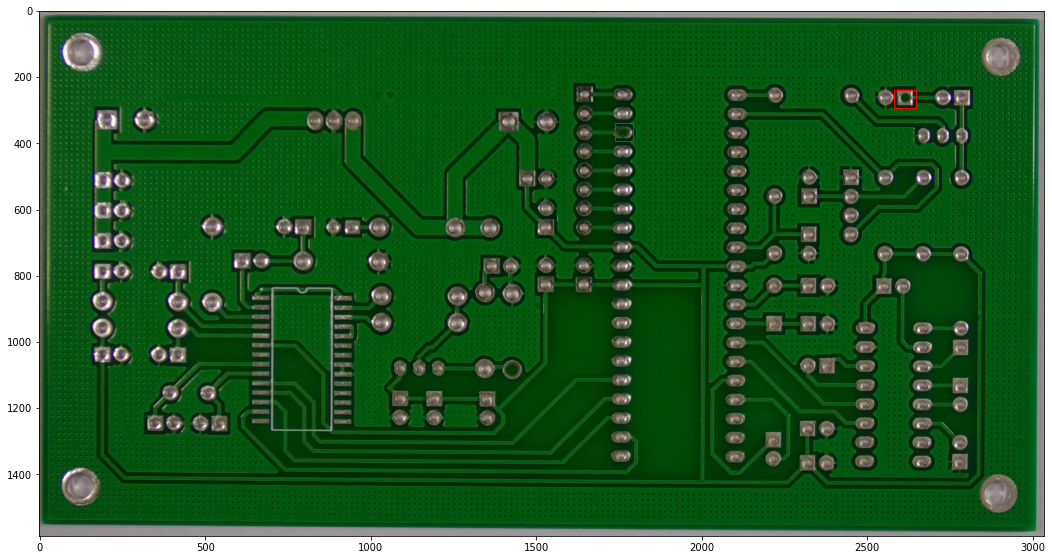

In [16]:
name = '01_missing_hole_07'
plot_image(name)

10_spur_01
[1134  722 1236  812]
[1984  473 2049  571]
[1050 1061 1117 1179]
[1514 1258 1584 1377]


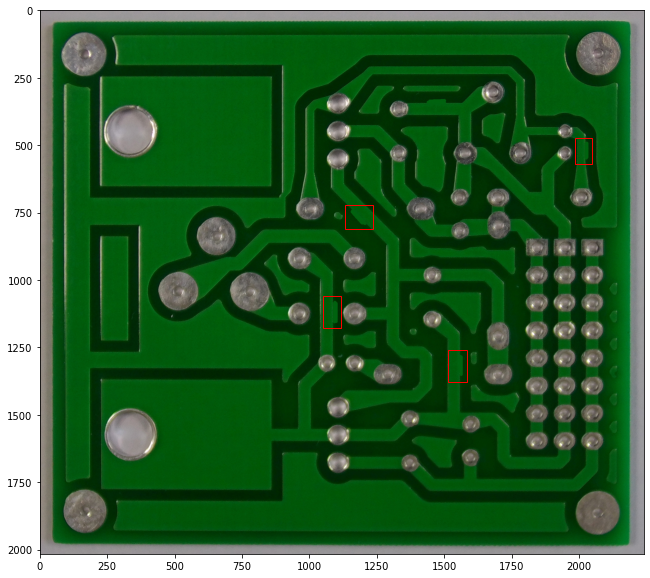

In [17]:
name = train.file[500]
plot_image(name)

08_mouse_bite_05
[1566 1202 1625 1264]
[1514  595 1586  643]
[1246 1326 1302 1387]
[2091  764 2138  818]


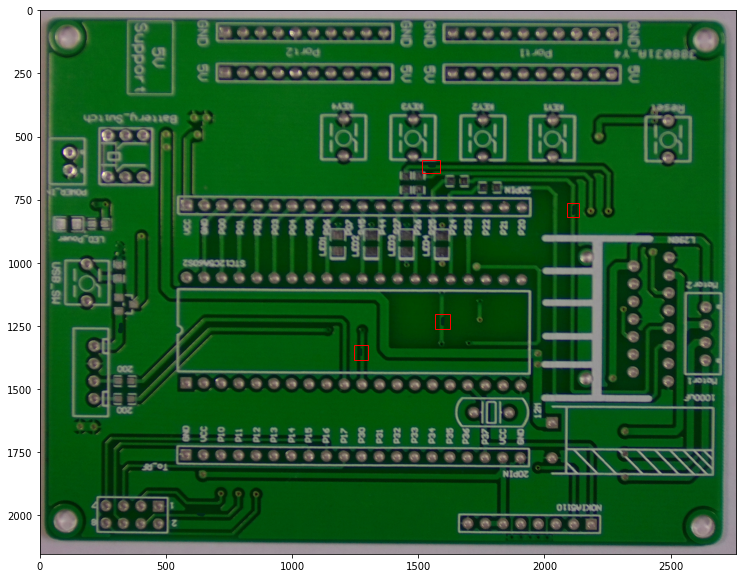

In [18]:
name = train.file[100]
plot_image(name)

07_mouse_bite_06
[1655  177 1777  255]
[696 398 799 462]
[2336  439 2387  520]
[2044  665 2098  724]
[880 863 953 934]


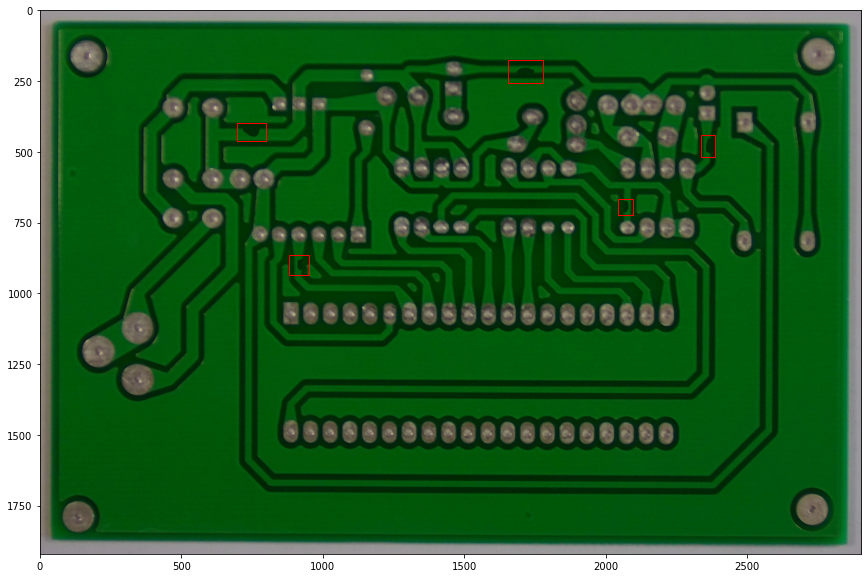

In [19]:
name = train.file[105]
plot_image(name)

# IV. Creating Custom database

In [20]:
class fcbData(object):
    def __init__(self, df, IMG_DIR, transforms): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['file'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        a = ''
        if "missing" in image_id.split('_'):
            a = 'Missing_hole/'
        elif "mouse" in image_id.split('_'):
            a = 'Mouse_bite/'
        elif "open" in image_id.split('_'):
            a = 'Open_circuit/'
        elif "short" in image_id.split('_'):
            a = 'Short/'
        elif "spur" in image_id.split('_'):
            a = 'Spur/'
        elif "spurious" in image_id.split('_'):
            a = 'Spurious_copper/'
        image_values = self.df[self.df['file'] == image_id]
        image = cv2.imread(self.img_dir+a+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

Define the image transformations. We'll use albumentations package: https://albumentations.ai/


In [21]:
# pip install -U albumentations

In [22]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [23]:
path ="/kaggle/input/pcb-defects/PCB_DATASET/images/"
fcb_dataset   = fcbData(df, path, get_train_transform())

In [24]:
first_data=fcb_dataset[0]

In [25]:
type(first_data), len(first_data), type(first_data[0]), type(first_data[1]), type(first_data[2])

(tuple, 3, torch.Tensor, dict, str)

In [26]:
print(first_data[0], first_data[1], first_data[2])

tensor([[[0.6157, 0.6235, 0.6196,  ..., 0.6235, 0.6275, 0.6353],
         [0.6078, 0.6157, 0.6118,  ..., 0.6235, 0.6196, 0.6275],
         [0.6078, 0.6118, 0.6118,  ..., 0.6157, 0.6078, 0.6118],
         ...,
         [0.6000, 0.5922, 0.6039,  ..., 0.6000, 0.5961, 0.5882],
         [0.6078, 0.5922, 0.5961,  ..., 0.6039, 0.6039, 0.6000],
         [0.6118, 0.5961, 0.5961,  ..., 0.6039, 0.6118, 0.6157]],

        [[0.5922, 0.6000, 0.5961,  ..., 0.6000, 0.6039, 0.6118],
         [0.5843, 0.5922, 0.5882,  ..., 0.6000, 0.5961, 0.6039],
         [0.5843, 0.5882, 0.5882,  ..., 0.5922, 0.5843, 0.5882],
         ...,
         [0.5765, 0.5686, 0.5804,  ..., 0.5922, 0.5882, 0.5804],
         [0.5843, 0.5686, 0.5725,  ..., 0.5961, 0.5961, 0.5922],
         [0.5882, 0.5725, 0.5725,  ..., 0.5961, 0.6039, 0.6078]],

        [[0.6078, 0.6157, 0.6118,  ..., 0.6157, 0.6196, 0.6275],
         [0.6000, 0.6078, 0.6039,  ..., 0.6157, 0.6118, 0.6196],
         [0.6000, 0.6039, 0.6039,  ..., 0.6078, 0.6000, 0.

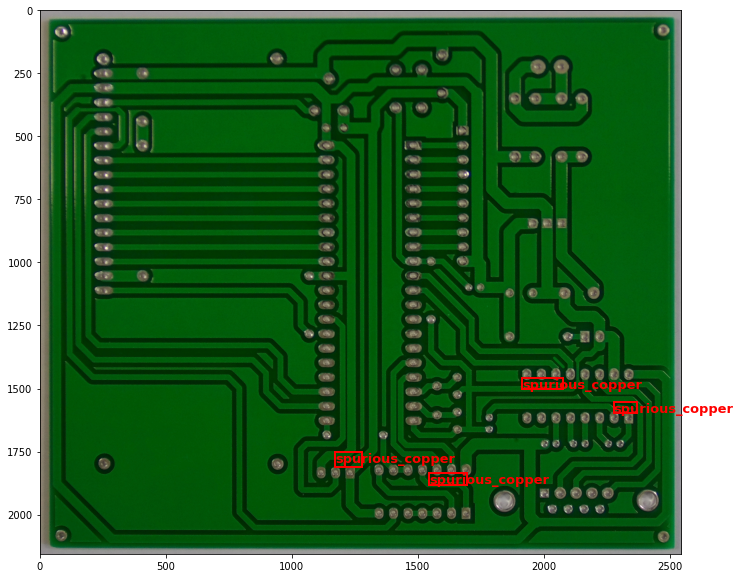

In [27]:
img, tar, _ = fcb_dataset[random.randint(0,50)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for j in tar["labels"].tolist():
    classes_la = {1:"missing_hole", 2: "mouse_bite", 3:"open_circuit",4: "short", 5:'spur',6:'spurious_copper'}
    l = classes_la[j]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [28]:
len(df)

2362

Split data into training and test

In [29]:
image_ids = df['file'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = df[df['file'].isin(valid_ids)]
train_df = df[df['file'].isin(train_ids)]
train_df.shape,valid_df.shape

((90, 8), (2272, 8))

# V. Dataloader

In [30]:
path

'/kaggle/input/pcb-defects/PCB_DATASET/images/'

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [32]:
train_dataset = fcbData(train_df, path, get_train_transform())
valid_dataset = fcbData(valid_df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

In [33]:
len(valid_data_loader)

665

Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 6

In [34]:
## num_classes = 6 # + background
num_classes = 6+1

# load a model; pre-trained on COCO
# .. fpn = 'feature pyramid network'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [35]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device ",device)

Using device  cuda


In [37]:
for name, params in model.named_parameters():
    if params.requires_grad and name.__contains__("predict"):
        print(name)

roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [38]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# VI. Training and evaluation

In [39]:
train_data_loader

In [40]:
def orthogonal_loss(lembda):
    extra_norm=0.
    for m in model.modules():
        if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
            tmp=m.weight.view(m.weight.data.size(0), -1) 
            s1,s2=tmp.shape # For unequal matrices semi orthogonal condition is imposed
            if s1<s2:
                extra_norm+=torch.norm(torch.mm(tmp,tmp.t())-torch.eye(s1).to(device),p='fro')
            else:
                extra_norm+=torch.norm(torch.mm(tmp.t(),tmp)-torch.eye(s2).to(device),p='fro')
    return extra_norm

In [41]:
import sys
num_epochs = 10
best_epoch = 0
min_loss = sys.maxsize
loss_curve=[]
IOU_measure=[]

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train()
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_value+=float(orthogonal_loss(0.01))
        loss_curve.append(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    print(f"Epoch #{epoch} loss: {loss_value}") 
        
#     validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        mean_IOU_tmp=[]
        for images, targets, image_ids in tk:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            mean_IOU_tmp.append(np.nanmean(IOU))
            tk.set_postfix(IoU=np.mean(IOU))
        IOU_measure.append(np.mean(mean_IOU_tmp))
        tk.close()

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #0 loss: 916.8539705828712


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #1 loss: 917.7252772412993


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #2 loss: 918.132023541373


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #3 loss: 918.2295176747612


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #4 loss: 918.2721300295817


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #5 loss: 918.3268217183928


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #6 loss: 918.3271309435249


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #7 loss: 918.3348690611899


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #8 loss: 918.3361211986784


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #9 loss: 918.3363852453851


  0%|          | 0/665 [00:00<?, ?it/s]

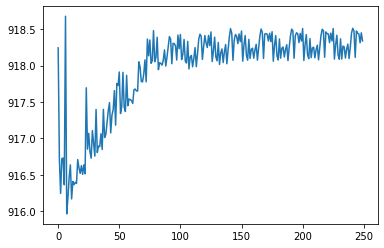

In [42]:
plt.plot(loss_curve)

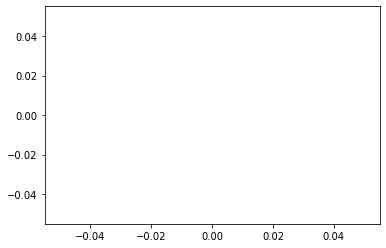

In [43]:
plt.plot(IOU_measure)

Sample evaluation on validation dataset image

In [44]:
img,target,_ = valid_dataset[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print(prediction)    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

{'boxes': tensor([[1821.9757, 1007.0383, 1865.1539, 1044.3693],
        [1805.1495,  997.3347, 1877.0804, 1048.7686],
        [1162.8412,  923.8015, 1206.4319,  979.2405],
        [1790.9749,  969.8806, 1905.3073, 1075.8881],
        [1151.5801,  912.1283, 1216.1973,  989.9799],
        [1812.6754,  993.8805, 1902.0323, 1055.4628],
        [1817.8037,  987.1036, 1907.3079, 1060.0942],
        [1825.9783,  986.3027, 1870.6886, 1052.8031],
        [1831.9235, 1001.0518, 1876.2555, 1039.9979],
        [1776.5828,  977.3943, 1867.6877, 1055.9159],
        [1791.2167,  985.5934, 1917.1416, 1048.8019],
        [2260.3242,  689.5727, 2316.6406,  737.0074],
        [1797.0347,  980.1953, 1924.0114, 1038.1362],
        [1783.1702,  988.4842, 1922.1796, 1049.6429],
        [1834.1090,  978.1716, 1931.0599, 1069.2964],
        [1150.6272,  916.4763, 1216.6910,  983.5821],
        [1809.5623,  999.9801, 1853.2396, 1039.4213],
        [ 225.3291, 1324.1527,  304.2295, 1413.3403],
        [1818.6447

In [45]:
torch.save(model.state_dict(), 'pcbdetection.pt')

# VII. Evaluation

In [46]:
y_true =[]
y_pred = []
for data in valid_dataset:
    img,target,_ = data
    model.eval()
    with torch.no_grad():
        y_true.append(target['labels'][0])
        prediction = model([img.to(device)])[0]
        if len(prediction['labels'])==0:
            y_pred.append(torch.tensor(0).to(device))
        else:
            y_pred.append(prediction['labels'][0])

In [47]:
yy_pred = []
for v in y_pred:
    yy_pred.append(v.cpu())

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, yy_pred)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  0, 109,   0,   0,   0,   0,   0],
       [ 13,  52,   0,  49,   0,   0,   0],
       [  9,  10,   0,  90,   1,   0,   0],
       [  3,  28,   0,  76,   4,   0,   0],
       [ 15,  63,   0,  32,   0,   0,   0],
       [ 13,  77,   0,  13,   2,   1,   5]])

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true, yy_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.32      1.00      0.49       109
           2       0.00      0.00      0.00       114
           3       0.35      0.82      0.49       110
           4       0.57      0.04      0.07       111
           5       0.00      0.00      0.00       110
           6       1.00      0.05      0.09       111

    accuracy                           0.31       665
   macro avg       0.32      0.27      0.16       665
weighted avg       0.37      0.31      0.19       665



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

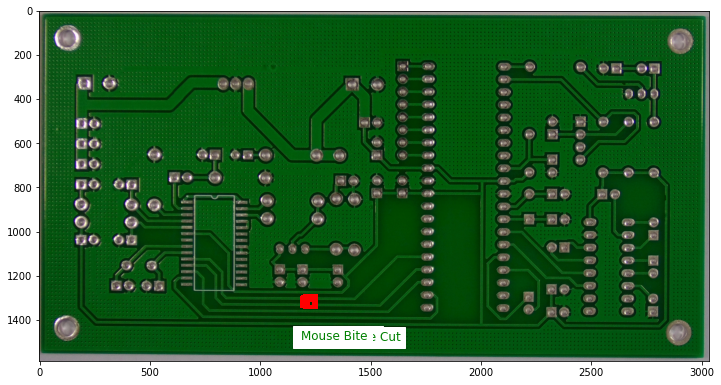

In [50]:
# Define the device for inference (CPU or GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

defect_names = {
    1: "Missing Hole",
    2: "Open Circuit",
    3: "Short Circuit",
    4: "Mouse Bite",
    5: "Spur",
    6: "Copper Trace Cut"
}
# Load the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=7)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=7)
model.load_state_dict(torch.load('/kaggle/working/pcbdetection.pt'))
model.eval()
model.to(device)

# Load the image
image_path = '/kaggle/input/pcb-defects/PCB_DATASET/images/Mouse_bite/01_mouse_bite_06.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0

# Define the transformation to apply to the image
transform = T.Compose([T.ToTensor()])

# Apply the transformation to the image
image = transform(image).to(device)

# Predict the bounding boxes and labels for the image
image = image.float()
outputs = model([image])
boxes = outputs[0]['boxes'].detach().cpu().numpy()
labels = outputs[0]['labels'].detach().cpu().numpy()

# Visualize the image and the predicted bounding boxes
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image.permute(1, 2, 0).cpu().numpy())
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    rect = matplotlib.patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1-20, y2 + 150, defect_names[label], fontsize=12, color='g', backgroundcolor='w')
plt.show()